<a href="https://colab.research.google.com/github/santiagorg2401/pytorch_course_exercises/blob/main/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision

## 0. Solve importations

In [1]:
import torch
import random
import torchvision
import pathlib as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from timeit import default_timer as timer
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy

import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download.")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary, plot_loss_curves

SEED = 42
BATCH_SIZE = 32

# Set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} on PyTorch version {torch.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

## 1. Load dataset

100%|██████████| 26421880/26421880 [00:02<00:00, 12428685.90it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205995.21it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3871268.86it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21722612.67it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Train samples: 60000. Test samples: 10000
Sample shape: torch.Size([1, 28, 28])
Number of classes: 10
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


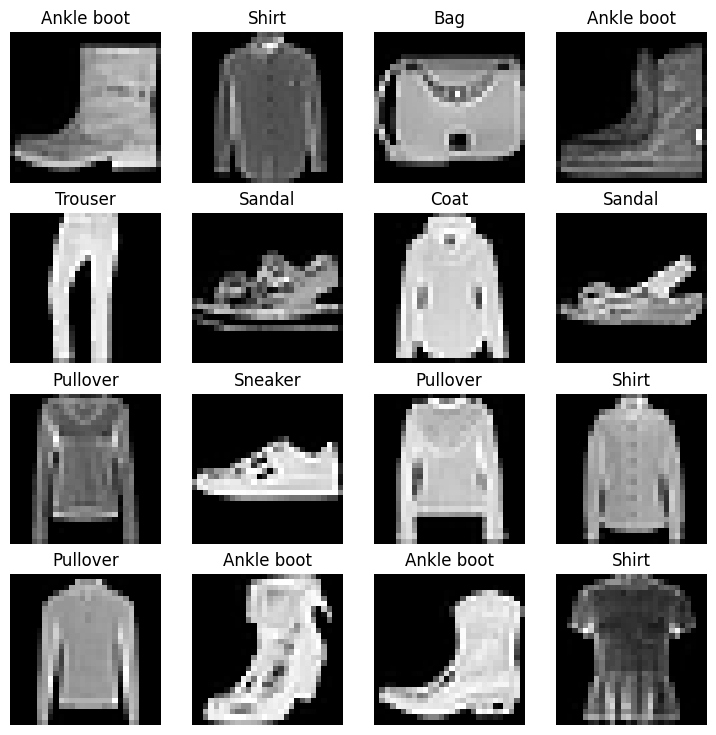

In [2]:
# Download datasets
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

class_names = train_data.classes

# Visualize training samples
torch.manual_seed(SEED)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  rand_i = torch.randint(0, len(train_data), size=[1]).item()
  img, lbl = train_data[rand_i]
  fig.add_subplot(rows, cols, i)
  plt.imshow(torch.squeeze(img), cmap="gray")
  plt.axis(False)
  plt.title(class_names[lbl])

# Print dataset info
m = f"Train samples: {len(train_data)}. Test samples: {len(test_data)}"\
    f"\nSample shape: {img.shape}"\
    f"\nNumber of classes: {len(class_names)}"\
    f"\nClasses: {class_names}"
print(m)

Features shape: torch.Size([32, 1, 28, 28]), Labels shape: torch.Size([32])


(-0.5, 27.5, 27.5, -0.5)

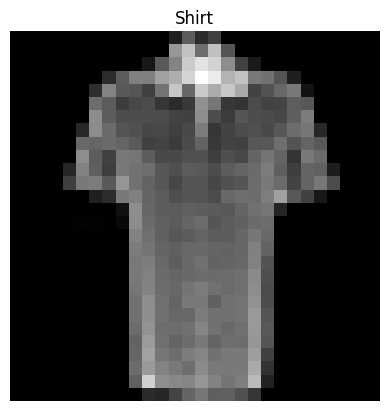

In [3]:
# Turn dataset into PyTorch Datasets using torch.utils.data.DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

# Check a sample
train_features_batch, train_labels_batch = next(iter(train_dataloader))
m = f"Features shape: {train_features_batch.shape}, "\
    f"Labels shape: {train_labels_batch.shape}"
print(m)

torch.manual_seed(SEED)
ran_i = torch.randint(0, len(train_features_batch), size=[1]).item()
img, lbl = train_features_batch[ran_i], train_labels_batch[ran_i]
plt.imshow(img.squeeze(), cmap="gray"); plt.title(class_names[lbl])
plt.axis(False)

## 2. Create a function to time model performance

In [4]:
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds.")
  return total_time

In [5]:
# Test it out
t0 = timer()
t1 = timer()
print_train_time(t0, t1, "cpu")

Train time on cpu: 0.000 seconds.


7.130000000188375e-05

## 3. `model_0` Baseline

### Build model class

In [6]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape, hidden_units),
        nn.Linear(hidden_units, output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)

### Setup training and testing loop
Using batches is different since loss is calculated per batch and model parameters are updated once per batch rather than once per epoch.

In [7]:
EPOCHS = 3; LOG_STEP = 1; LEARNING_RATE=1E-2

# Initialize model
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)
model_0 = FashionMNISTModelV0(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names))

# Create a loss function, an optimizer and a metrics function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=LEARNING_RATE)
accuracy_fn = Accuracy(task="multiclass",
                       num_classes=len(class_names))

# Start timer
model_0_t0_cpu = timer()

# Use tqdm progress bar
for epoch in tqdm(range(EPOCHS)):
  print(f"-------------Epoch: {epoch}-------------")
  # Training loop
  train_loss, acc = 0, 0
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    acc += accuracy_fn(y_pred.argmax(dim=1), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Calculate average loss per epoch
  train_loss /= len(train_dataloader)
  acc /= len(train_dataloader)

  # Testing loop
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X, y in test_dataloader:
      test_pred = model_0(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  # Log experiment data
  if epoch % LOG_STEP == 0 or epoch == EPOCHS - 1:
    m = f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {100*acc:.2f}%" \
        f"| Test loss: {test_loss:.5f} | Test accuracy: {100*test_acc:.2f}%"
    print(m)

# Calculate training time
model_0_t1_cpu = timer()
model_0_time = print_train_time(model_0_t0_cpu,
                                model_0_t1_cpu,
                                str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

-------------Epoch: 0-------------
Epoch: 0 | Loss: 0.42786 | Accuracy: 70.75%| Test loss: 0.63220 | Test accuracy: 77.97%
-------------Epoch: 1-------------
Epoch: 1 | Loss: 0.51471 | Accuracy: 81.07%| Test loss: 0.55831 | Test accuracy: 80.79%
-------------Epoch: 2-------------
Epoch: 2 | Loss: 0.30495 | Accuracy: 82.81%| Test loss: 0.51054 | Test accuracy: 82.22%
Train time on cpu: 44.319 seconds.


### Make predictions

In [8]:
def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device):
  """Returns a dictionary containig the results of model predicting on data_loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_pred.argmax(dim=1), y)

    loss /= len(data_loader)
    acc /= len(data_loader) / 100

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc.item()}

In [9]:
model_0_results = eval_model(model_0,
                             test_dataloader,
                             loss_fn,
                             accuracy_fn,
                             "cpu")
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5101204514503479,
 'model_acc': 82.23841857910156}

## 4. `model_1` Include non linearity

### Set up device agnostic code


### Build model class

In [10]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_shape),
        nn.ReLU()
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)

### Setup training and testing loop
Create a training and testing function

In [11]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device):
  """Trains model with the dataset located on data_loader."""
  # Training loop
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Calculate average loss and accuracy per epoch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device):
  """Tests model with the dataset located on data_loader."""
  # Testing loop
  test_loss, test_acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1), y)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  return test_loss, test_acc

In [12]:
EPOCHS = 3; LOG_STEP = 1; LEARNING_RATE = 1E-1

# Initialize model
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)
model_1 = FashionMNISTModelV1(784,
                              10,
                              len(class_names)).to(device)

# Create a loss function, an optimizer and a metrics function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=LEARNING_RATE)
accuracy_fn = Accuracy(task="multiclass",
                       num_classes=len(class_names)).to(device)

model_1_t0 = timer()

# Use tqdm progress bar
for epoch in tqdm(range(EPOCHS)):
  print(f"-------------Epoch: {epoch}-------------")
  # Training loop
  train_loss, train_acc = train_step(model=model_1,
                                     data_loader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     accuracy_fn=accuracy_fn,
                                     device=device)

  # Testing loop
  test_loss, test_acc = test_step(model=model_1,
                                  data_loader=test_dataloader,
                                  loss_fn=loss_fn,
                                  accuracy_fn=accuracy_fn,
                                  device=device)

  # Log experiment data
  if epoch % LOG_STEP == 0 or epoch == EPOCHS - 1:
    m = f"Epoch: {epoch} | " \
        f"Loss: {train_loss:.5f} | Accuracy: {100*train_acc:.2f}%" \
        f"| Test loss: {test_loss:.5f} | Test accuracy: {100*test_acc:.2f}%"
    print(m)

model_1_t1 = timer()
model_1_time = print_train_time(start=model_1_t0,
                                end=model_1_t1,
                                device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

-------------Epoch: 0-------------
Epoch: 0 | Loss: 1.05878 | Accuracy: 62.19%| Test loss: 0.99613 | Test accuracy: 64.09%
-------------Epoch: 1-------------
Epoch: 1 | Loss: 0.91179 | Accuracy: 66.32%| Test loss: 0.95756 | Test accuracy: 65.47%
-------------Epoch: 2-------------
Epoch: 2 | Loss: 0.88172 | Accuracy: 67.25%| Test loss: 0.89043 | Test accuracy: 67.08%
Train time on cuda: 80.891 seconds.


### Make predictions

In [13]:
model_1_results = eval_model(model_1,
                             test_dataloader,
                             loss_fn,
                             accuracy_fn,
                             device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.8907334804534912,
 'model_acc': 67.07267761230469}

## 5. `model_2` CNN

### Build model class

In [14]:
class FashionMNISTModelV2(nn.Module):
  """
  TinyVGG architecture. Model from CNN explainer.
  """
  def __init__(self,
               input_shape:int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels= input_shape,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.Conv2d(in_channels= hidden_units,
                  out_channels= hidden_units,
                  kernel_size= 3,
                  stride= 1,
                  padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features= hidden_units * 7 * 7,
                  out_features= output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

### Setup training and testing loop

In [15]:
EPOCHS = 10; LOG_STEP = 2; LEARNING_RATE = 1E-2

# Initialize model
torch.manual_seed(SEED); torch.cuda.manual_seed(SEED)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

# Create a loss function, an optimizer and a metrics function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=LEARNING_RATE)
accuracy_fn = Accuracy(task="multiclass",
                       num_classes=len(class_names)).to(device)

model_2_t0 = timer()

# Use tqdm progress bar
for epoch in tqdm(range(EPOCHS)):
  print(f"-------------Epoch: {epoch}-------------")
  # Training loop
  train_loss, train_acc = train_step(model=model_2,
                                     data_loader=train_dataloader,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                     accuracy_fn=accuracy_fn,
                                     device=device)

  # Testing loop
  test_loss, test_acc = test_step(model=model_2,
                                  data_loader=test_dataloader,
                                  loss_fn=loss_fn,
                                  accuracy_fn=accuracy_fn,
                                  device=device)
  # Log experiment data
  if epoch % LOG_STEP == 0 or epoch == EPOCHS - 1:
    m = f"Epoch: {epoch} | " \
        f"Loss: {train_loss:.5f} | Accuracy: {100*train_acc:.2f}%" \
        f"| Test loss: {test_loss:.5f} | Test accuracy: {100*test_acc:.2f}%"
    print(m)

model_2_t1 = timer()
model_2_time = print_train_time(start=model_2_t0,
                                end=model_2_t1,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

-------------Epoch: 0-------------
Epoch: 0 | Loss: 1.03547 | Accuracy: 62.31%| Test loss: 0.64526 | Test accuracy: 77.01%
-------------Epoch: 1-------------
-------------Epoch: 2-------------
Epoch: 2 | Loss: 0.45557 | Accuracy: 83.67%| Test loss: 0.44542 | Test accuracy: 83.95%
-------------Epoch: 3-------------
-------------Epoch: 4-------------
Epoch: 4 | Loss: 0.38606 | Accuracy: 86.17%| Test loss: 0.39769 | Test accuracy: 86.13%
-------------Epoch: 5-------------
-------------Epoch: 6-------------
Epoch: 6 | Loss: 0.35123 | Accuracy: 87.48%| Test loss: 0.36593 | Test accuracy: 87.16%
-------------Epoch: 7-------------
-------------Epoch: 8-------------
Epoch: 8 | Loss: 0.32863 | Accuracy: 88.21%| Test loss: 0.34914 | Test accuracy: 87.65%
-------------Epoch: 9-------------
Epoch: 9 | Loss: 0.32107 | Accuracy: 88.56%| Test loss: 0.36253 | Test accuracy: 86.93%
Train time on cuda: 197.510 seconds.


### Make predictions

In [16]:
model_2_results = eval_model(model_2,
                             test_dataloader,
                             loss_fn,
                             accuracy_fn,
                             device)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.36338353157043457,
 'model_acc': 86.91093444824219}

## 6. Compare results

In [17]:
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.510120,82.238419
1,FashionMNISTModelV1,0.890733,67.072678
2,FashionMNISTModelV2,0.363384,86.910934


In [18]:
# Add training time to results comparison
compare_results["training_time"] = [model_0_time, model_1_time, model_2_time]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.510120,82.238419,44.319118
1,FashionMNISTModelV1,0.890733,67.072678,80.891408
2,FashionMNISTModelV2,0.363384,86.910934,197.509790


Text(0, 0.5, 'model')

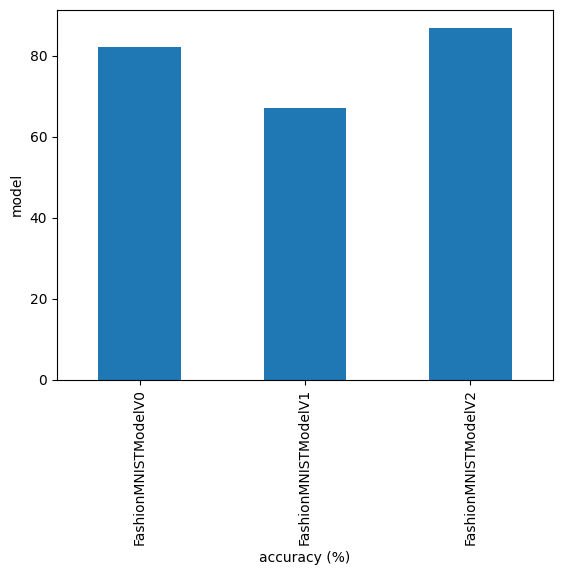

In [19]:
compare_results.set_index("model_name")["model_acc"].plot(kind="bar")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## 7. Plot predictions

In [20]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Pass data to cpu
      pred_probs.append(pred_prob.to("cpu"))

  return torch.stack(pred_probs)

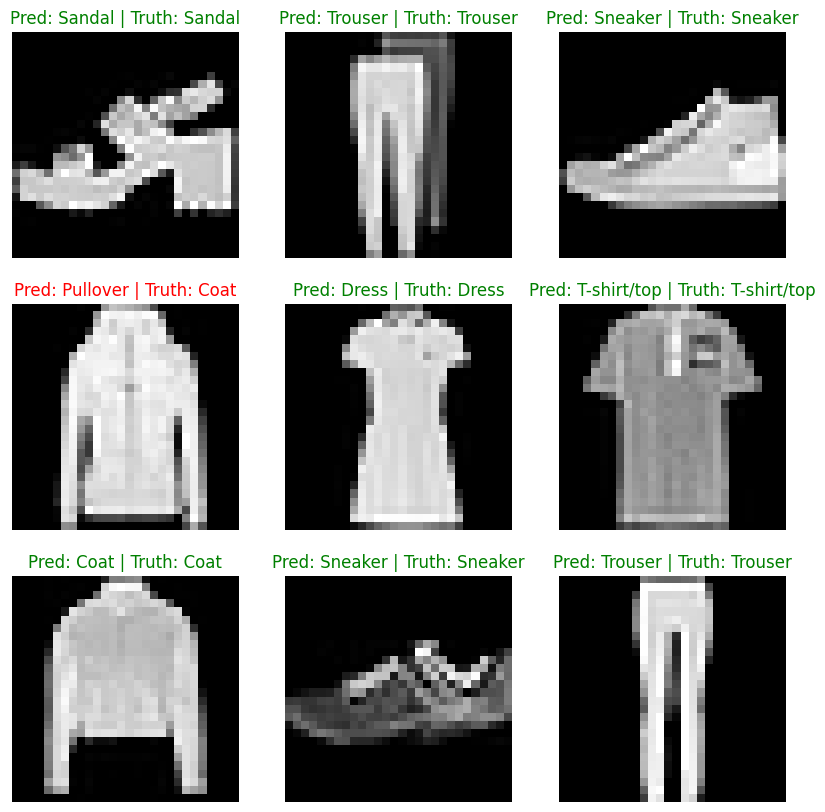

In [21]:
W = 3; H = 3
random.seed(SEED)
test_samples = []
test_labels = []

# Get random samples from test dataset
for sample, label in random.sample(list(test_data), k=W*H):
  test_samples.append(sample)
  test_labels.append(label)

# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples,
                              device=device)
pred_classes = pred_probs.argmax(dim=1)

plt.figure(figsize=(10, 10))
for i, sample in enumerate(test_samples):
  plt.subplot(H, W, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  plt.axis(False)
  pred_lbl = class_names[pred_classes[i]]
  truth_lbl = class_names[test_labels[i]]
  m = f"Pred: {pred_lbl} | Truth: {truth_lbl}"
  if pred_lbl == truth_lbl:
    plt.title(m, c="g")
  else:
    plt.title(m, c="r")

## 8. Confusion matrix

In [22]:
import mlxtend

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

mlxtend.__version__

'0.22.0'

Making predictions ...:   0%|          | 0/313 [00:00<?, ?it/s]

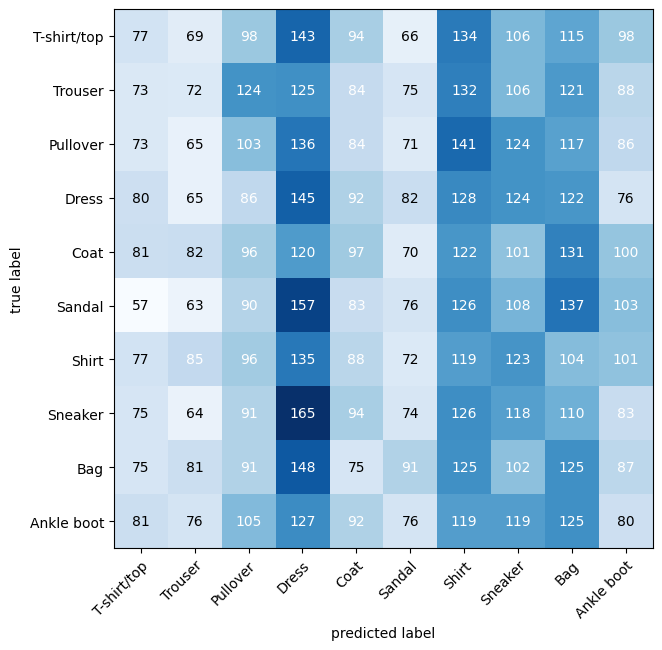

In [23]:
# Make predictions and save them in a tensor
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions ..."):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)
fig, ax = plot_confusion_matrix(conf_mat= confmat_tensor.numpy(),
                                class_names= class_names,
                                figsize=(10, 7))

## 9. Save and load best model

In [24]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision.pth


In [25]:
torch.manual_seed(SEED)
loaded_model = FashionMNISTModelV2(input_shape=1,
                                   hidden_units=10,
                                   output_shape=len(class_names))
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [27]:
model_loaded_results = eval_model(model=loaded_model,
                                  data_loader=test_dataloader,
                                  loss_fn=loss_fn,
                                  accuracy_fn=accuracy_fn,
                                  device=device)
model_loaded_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.36267369985580444,
 'model_acc': 86.94088745117188}

In [33]:
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(model_loaded_results["model_loss"]),
              atol=1e-3)

tensor(True)